In [2]:
# !wget -O "./data/coco.zip" http://images.cocodataset.org/zips/val2017.zip
# # extract the zip file
# !unzip "./data/coco.zip" -d "./data/coco"

In [3]:
from deeplake.core.vectorstore.deeplake_vectorstore import VectorStore
import os
import torch
from torchvision import transforms, models
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image

images_path = "./data/coco/val2017"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/home/aakash/miniconda3/envs/honeybee/lib/python3.10/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.25) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [4]:
model = models.resnet18(pretrained=True)

return_nodes = {"avgpool": "embedding"}
model = create_feature_extractor(model, return_nodes=return_nodes)

model.eval()
model.to(device)

/home/aakash/miniconda3/envs/honeybee/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aakash/miniconda3/envs/honeybee/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [5]:
tform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], dim=0) if x.shape[0] == 1 else x
        ),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


def embedding_function(images, model=model, transform=tform, batch_size=4):
    """Creates a list of embeddings based on a list of image filenames. Images are processed in batches."""

    if isinstance(images, str):
        images = [images]

    # Proceess the embeddings in batches, but return everything as a single list
    embeddings = []
    for i in range(0, len(images), batch_size):
        batch = torch.stack(
            [transform(Image.open(item)) for item in images[i : i + batch_size]]
        )
        batch = batch.to(device)
        with torch.no_grad():
            embeddings += model(batch)["embedding"][:, :, 0, 0].cpu().numpy().tolist()

    return embeddings

In [10]:
vector_store_path = "pg_essay_deeplake"

vector_store = VectorStore(
    path=vector_store_path,
    tensor_params=[
        {"name": "image", "htype": "image", "sample_compression": "jpg"},
        {"name": "embedding", "htype": "embedding"},
        {"name": "filename", "htype": "text"},
    ],
)

In [11]:
image_fns = [
    os.path.join(images_path, item)
    for item in os.listdir(images_path)
    if os.path.splitext(item)[-1] == ".jpg"
]

In [12]:
vector_store.add(
    image=image_fns,
    filename=image_fns,
    embedding_function=embedding_function,
    embedding_data=image_fns,
)

Creating 5000 embeddings in 10 batches of size 500::   0%|          | 0/10 [00:00<?, ?it/s]/home/aakash/miniconda3/envs/honeybee/lib/python3.10/site-packages/deeplake/core/chunk/base_chunk.py:422: UserWarning: Grayscale images will be reshaped from (H, W) to (H, W, 1) to match tensor dimensions. This warning will be shown only once.
  warnings.warn(message)
Creating 5000 embeddings in 10 batches of size 500:: 100%|██████████| 10/10 [02:03<00:00, 12.38s/it]

Dataset(path='pg_essay_deeplake', tensors=['image', 'embedding', 'filename', 'id'])

  tensor      htype                shape               dtype  compression
  -------    -------              -------             -------  ------- 
   image      image    (5000, 145:640, 200:640, 1:3)   uint8    jpeg   
 embedding  embedding           (5000, 512)           float32   None   
 filename     text               (5000, 1)              str     None   
    id        text               (5000, 1)              str     None   


In [13]:
image_path = "image.png"

result = vector_store.search(
    embedding_data=image_path,
    embedding_function=embedding_function,
    return_tensors=["id", "filename", "embedding"],
    return_view=False,
)

print(result)

{'score': [0.8733397126197815, 0.8487871885299683, 0.8402624726295471, 0.8321881294250488], 'id': ['ad3dd01e-e523-11ee-8eec-00155d86837f', 'ad3cadec-e523-11ee-8eec-00155d86837f', 'ad3db354-e523-11ee-8eec-00155d86837f', 'ad3dc04c-e523-11ee-8eec-00155d86837f'], 'filename': ['./data/coco/val2017/000000541123.jpg', './data/coco/val2017/000000076468.jpg', './data/coco/val2017/000000493905.jpg', './data/coco/val2017/000000516038.jpg'], 'embedding': [array([7.7841961e-01, 7.0882666e-01, 9.2673773e-01, 8.1063110e-01,
       6.9792032e-01, 1.2472656e+00, 1.3183889e+00, 4.2593414e-01,
       7.6707676e-02, 1.4129477e+00, 7.1160281e-01, 9.6427202e-01,
       6.1957449e-01, 4.1060832e-01, 3.2629904e-01, 9.4460559e-01,
       3.4329524e+00, 1.0055319e+00, 1.7915300e-01, 3.1709275e-01,
       2.3246302e-01, 5.3138423e-01, 6.4359683e-01, 1.6529608e+00,
       2.8191629e-01, 1.4529736e+00, 8.2675922e-01, 7.1529794e-01,
       3.2721850e-01, 1.2165425e+00, 1.4525952e+00, 5.2535194e-01,
       1.4101377

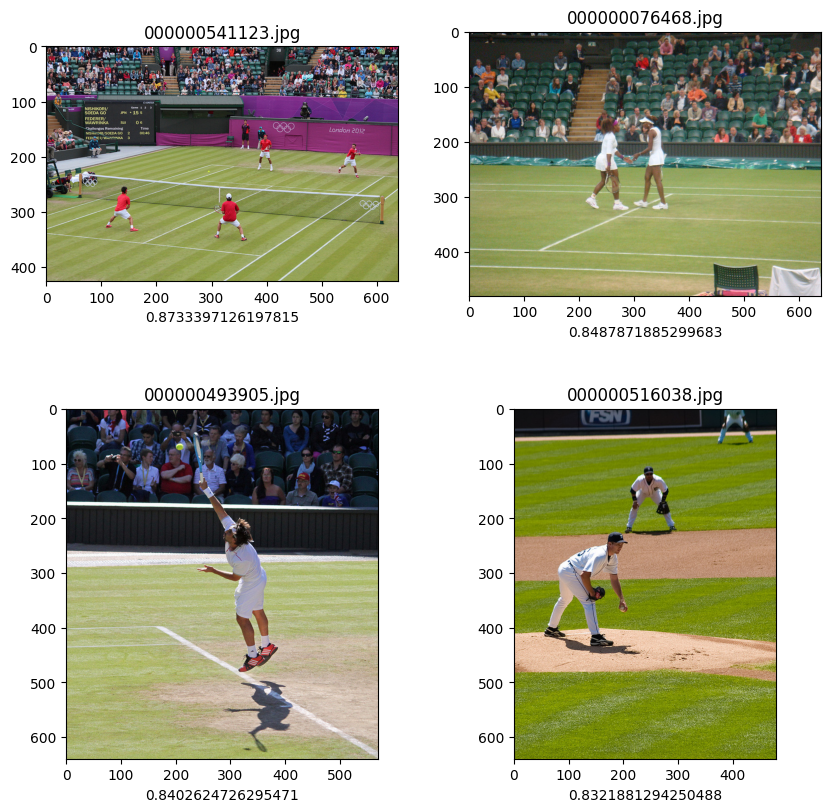

In [14]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

n = len(result["id"])
rows = int(math.sqrt(n))
cols = math.ceil(n / rows)

fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
for i in range(n):
    img = mpimg.imread(result["filename"][i])
    row = i // cols
    col = i % cols
    ax[row, col].imshow(img)
    ax[row, col].set_title(result["filename"][i].split("/")[-1])
    ax[row, col].set_xlabel(result["score"][i])

In [15]:
vector_store.summary()

Dataset(path='pg_essay_deeplake', tensors=['image', 'embedding', 'filename', 'id'])

  tensor      htype                shape               dtype  compression
  -------    -------              -------             -------  ------- 
   image      image    (5000, 145:640, 200:640, 1:3)   uint8    jpeg   
 embedding  embedding           (5000, 512)           float32   None   
 filename     text               (5000, 1)              str     None   
    id        text               (5000, 1)              str     None   


In [16]:
image_path = "image.png"

result = vector_store.search(
    embedding_data=image_path,
    embedding_function=embedding_function,
    return_tensors=["id", "filename", "embedding"],
    return_view=True,
)

print(result)

Dataset(path='pg_essay_deeplake', index=Index([(4653, 650, 4279, 4453)]), tensors=['image', 'embedding', 'filename', 'id'])


In [17]:
result.embedding[0].tobytes()

b'\x82FG?\xaau5?\xaf>m?\x85\x85O?\xe8\xaa2?f\xa6\x9f?\xf8\xc0\xa8?\n\x14\xda>\xea\x18\x9d=x\xdb\xb4?\x9a+6?\x88\xdav?o\x9c\x1e?A;\xd2>\xab\x10\xa7>\xac\xd1q?~\xb5[@E\xb5\x80?\xe2s7>\xfbY\xa2>\xc9\nn>\xcc\x08\x08?\xc3\xc2$?8\x94\xd3?UW\x90>\n\xfb\xb9?~\xa6S?\xc4\x1d7?/\x89\xa7>\xaa\xb7\x9b?\xa4\xee\xb9?w}\x06?\xeae\x10>ir\xef?$\xac\xf0?\xbca\xd8?qe\xb3>\xc5\x83U?4\xde\xc3?\xf7\x07\x93>\x1e\xae\x9f>\xf9y\x02@9\xfc\x86?\xcd\x84\x90<7\x8c\xc3<>\nV<c\x01U>\xca=:?E.v@\xd2\xd9\xdc>\xd3\x8cf?}f\xda?\x02y\xd6?\x92j\xb7>\'\x1b\xf7?\xc2\x14\x8f?\xd6\xf9\xe5<\xd3b\x89?\x9a\x0f\xfb?\xb1\x03\xbb>\x84/]?\xd8\x16\x8d?\x1f\x04\xb2<f\xaa\xf0>+\x05\xa6?\xa93\xee>\xe8{*@\xc6F\xb0>\xa4\x1b\xdc>\xb4M\xa2>\xad\xd6@@\x88\xe2\xf5<\xfd!\xd6?\x1d\xd5\x9d>JY\xe9>8\x1b\x99?E\xf9\xd2=\xa8\xdal?^\x93\xca?\x1c\xdc>?\xf8\xf1\xbc>3\x9d,@\xfcH\x81?\r\xeb<@\xd9\xee\x8e>\xe0\xc9\x0b@\xa76Z>g\xce)?\xd6\xe1??b\xe9/@\x1a\t\xac?4\xc3\x80?>\xf3\x96?\xf5M\x81?30\xc0>\x02\x90\x99?+D\x1e?Hw\x8d?\x890\x85>\\\xf08=\x00\x00\x00\x00\

In [18]:
tform = transforms.Compose(
    [
        transforms.RandomRotation(20),  # Image augmentation
        transforms.ToTensor(),  # Must convert to pytorch tensor for subsequent operations to run
        transforms.Normalize([0.5], [0.5]),
        # reshape the image to the correct size
        transforms.Resize((224, 224)),
    ]
)
train_loader = result.pytorch(
    num_workers=8,
    shuffle=False,
    transform={"image": tform, "filename": None},
    batch_size=4,
    decode_method={"image": "pil"},
)

In [19]:
for i, data in enumerate(train_loader):
    inputs = data["image"]
    print(inputs.shape)

torch.Size([4, 3, 224, 224])
